# Looking for the best place for a bookstore-cafeteria

The business idea of ​​this project is to find the best place for a bookstore-cafeteria.

First of all, I'm going to import the libraries I need for the project. 

In [1]:
import numpy as np
import pandas as pd
import geocoder
from geopy.geocoders import Nominatim
import requests
import urllib.request
import matplotlib.pyplot as plt  
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
import folium 

This project requires the neighborhoods of the city of Guadalajara, these neighborhoods together with their zip code will be obtained from the page of the Mexican postal service: https://www.correosdemexico.gob.mx/SSLServicios/ConsultaCP/Descarga.aspx. 
The format file is csv, so I'm going to import it.

In [2]:
data =  pd.read_csv('CodigosPostalesGuadalajara.csv', encoding='utf-8')
data.head()

,Código Postal,Estado,Municipio,Ciudad,Tipo de Asentamiento,Asentamiento
0,44100,Jalisco,Guadalajara,Guadalajara,Colonia,Guadalajara Centro
1,44110,Jalisco,Guadalajara,Guadalajara,Fraccionamiento,Vallarta Poniente
2,44130,Jalisco,Guadalajara,Guadalajara,Colonia,Arcos Vallarta
3,44130,Jalisco,Guadalajara,Guadalajara,Fraccionamiento,Arcos
4,44140,Jalisco,Guadalajara,Guadalajara,Colonia,Obrera Centro


I',m interested only in 'Código Postal', 'Estado', 'Ciudad' and 'Asentamiento'.

So, I'm going to create a dataframe with this columns and I'm going to rename them in english

In [3]:
postal_code = data[['Código Postal', 'Estado', 'Ciudad', 'Asentamiento']]
postal_code.rename(columns={'Código Postal': 'Code','Estado':'State','Ciudad':'City','Asentamiento':'Borough'},inplace=True)
postal_code.head()

,Code,State,City,Borough
0,44100,Jalisco,Guadalajara,Guadalajara Centro
1,44110,Jalisco,Guadalajara,Vallarta Poniente
2,44130,Jalisco,Guadalajara,Arcos Vallarta
3,44130,Jalisco,Guadalajara,Arcos
4,44140,Jalisco,Guadalajara,Obrera Centro


I want to know a little more about the columns, for example the data type of each one

In [4]:
postal_code.dtypes

Code        int64
State      object
City       object
Borough    object
dtype: object

As we can observe, Postal_Code is an interger, but I need it like string, because it will be easier to merge later

In [5]:
postal_code.Code = postal_code.Code.astype(str)
postal_code.dtypes

Code       object
State      object
City       object
Borough    object
dtype: object

Now it is ready, I want to know more about my dataset.  For example, How many boroughs do i have?

In [6]:
postal_code.Borough.value_counts()

Pablo Valdez             3
San Antonio              3
Arandas                  2
Lagos de Oriente         2
El Rosario               2
                        ..
Guadalupana Sur          1
Santa Rosa               1
Villas de La Barranca    1
Balcones de Huentitán    1
Jardines Del Rosario     1
Name: Borough, Length: 433, dtype: int64

In [7]:
postal_code.State.value_counts()

Jalisco    449
Name: State, dtype: int64

In [8]:
postal_code.City.value_counts()

Guadalajara    449
Name: City, dtype: int64

In [9]:
postal_code.shape

(449, 4)

I have 449 boroughs of Guadalajara City, I'm sure that dataset is only about Guadalajara, Jalisco

Once I have this information, I want to find the geocoding of the postal codes so, I will use the Nominatim library for it

In [10]:
#I define the features I need to gecode
boroughs = postal_code.Borough
cities = postal_code.City
states = postal_code.State
codes = postal_code.Code

In [ ]:
geolocator = Nominatim(user_agent='bookstore-cafeteria')

boroughs_list=[]
for borough,city, state, code in zip(boroughs,cities, states, codes):
    location = geolocator.geocode(borough+','+city+','+state+','+code)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
    else:
        boroughs_list.append([latitude,longitude,code,borough])
    

In [14]:
    gdl_boroughs = pd.DataFrame(boroughs_list)
    gdl_boroughs.columns = ['Latitude', 'Longitude', 'Code','Borough']
    gdl_boroughs

,Latitude,Longitude,Code,Borough
0,20.676399,-103.347910,44100,Guadalajara Centro
1,20.673296,-103.391970,44110,Vallarta Poniente
2,20.673495,-103.381072,44130,Arcos Vallarta
3,20.673495,-103.381072,44130,Arcos
4,20.670008,-103.371917,44140,Obrera Centro
...,...,...,...,...
160,20.688022,-103.291792,44716,Circunvalación Oblatos
161,20.646170,-103.328274,44720,Arandas
162,20.684594,-103.282771,44723,Plutarco Elias Calles 1
163,20.696765,-103.303591,44724,San Eugenio


In [15]:
gdl_boroughs.to_csv('gdlBoroughs.csv')

We can observe that Nominatim geocode 266 boroughs of 449

Then, we're going to use this 266 boroughs.

I want to see the geographical distribution of this boroughs. So, I'm going to map the points with Folium

In [116]:
latitude= '20.676399'
longitude = '-103.347910'

map_gdl = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough in zip(gdl_boroughs['Latitude'], gdl_boroughs['Longitude'], gdl_boroughs['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gdl)  

In [17]:
map_gdl

At this moment we're going to look for universities in the boroughs and I'm going to use Foursquare API.

The ID category for University is '4bf58dd8d48988d1ae941735'

I'm introducing the keys for Foursquare

In [18]:
CLIENT_ID = '4Y1FTTNOPFH31PJVW40TYORZQTS44JOSAFDLRMV0ONGG3MDN' # your Foursquare ID
CLIENT_SECRET = 'V5EMSPJ4EVHRNEJ3JPZHDKWJTCUSPA4MXQM0SOV5IAEQOJMZ' #your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

UNIVERSITY_ID = '4bf58dd8d48988d1ae941735'
CAFETERIA_ID= '4bf58dd8d48988d128941735'
BOOKSTORE_ID= '4bf58dd8d48988d114951735'
CAFE_ID = '4bf58dd8d48988d16d941735'
LIBRARY_ID = '4bf58dd8d48988d12f941735'


# Client Id
# GXXXLRCNJ5TILYFRIEADOJH2AQXOVIFSOTEHJVKSLEBACSI3

# Client Secret
# IPOLHWW2O2YMQYYHAA0BFGKQ2QRZBLLILGXTWSLC3AY3NCCE

I'm going to create a function that returns the universities info for each neighborhood in Guadalajara

In [19]:
def getUniversities(category_name,names, latitudes, longitudes, radius=250):
    
    university_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            UNIVERSITY_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        university_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_university = pd.DataFrame([item for university_list in university_list for item in university_list])
    nearby_university.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_university)

In [20]:
gdl_universities = getUniversities(UNIVERSITY_ID,names=gdl_boroughs['Borough'],
                                   latitudes=gdl_boroughs['Latitude'],
                                   longitudes=gdl_boroughs['Longitude']
                                  )

In [21]:
gdl_universities.to_csv('gdl.universities.csv')

In [22]:
gdl_uni_lat_long = gdl_universities[['Neighborhood',      
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']]
gdl_uni_lat_long.rename(columns = {'Neighborhood':'Borough','Venue':'University','Venue Latitude':'Latitude','Venue Longitude':'Longitude'},inplace=True)


In [23]:
gdl_uni_lat_long.groupby('Borough').count().sort_values(by='University', ascending=False)

,University,Latitude,Longitude
Borough,,,
Alcalde Barranquitas,5,5,5
Barragán y Hernández,4,4,4
Americana,3,3,3
Providencia Sur,3,3,3
Obrera Centro,3,3,3
Obrera,3,3,3
Ladrón de Guevara,3,3,3
La Normal,3,3,3
Guadalajara Centro,3,3,3


In [24]:
latitude= '20.676399'
longitude = '-103.347910'

map_gdl_uni = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, university in zip(gdl_uni_lat_long['Latitude'], gdl_uni_lat_long['Longitude'], gdl_uni_lat_long['University']):
    label = '{}'.format(university)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#ff4c4c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gdl_uni)  

In [25]:
map_gdl_uni

Now we obtain the boroughs with universities, we need to locate the cofee consumer zones and
We're going to use Foursquare with category = cafeteria

In [26]:
def getCategory(category_name,names, latitudes, longitudes, radius=500):
    
    cafeteria_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category_name,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        cafeteria_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_cafeteria = pd.DataFrame([item for cafeteria_list in cafeteria_list for item in cafeteria_list])
    nearby_cafeteria.columns = ['University', 
                  'University Latitude', 
                  'University Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_cafeteria)

In [27]:
gdl_cafeterias = getCategory(CAFETERIA_ID,names=gdl_uni_lat_long['University'],
                                   latitudes=gdl_uni_lat_long['Latitude'],
                                   longitudes=gdl_uni_lat_long['Longitude']
                                  )

In [28]:
gdl_cafeterias.Venue.value_counts()

COPARMEX Jalisco                                               12
Café Punta del Cielo.                                          12
Fitzroy Espresso Bar                                           10
Cafetería                                                      10
Natos Café                                                      8
Cafetería El Gabo                                               8
Mr mollete                                                      4
CREP ART                                                        3
La Casa del Waffle Libertad                                     3
Cafetería La Fórmula                                            3
Cafetería La Antigua                                            3
Casa Cafeto                                                     3
Casa Volta                                                      3
Neufeld                                                         3
Cafetería Centro Universitario Enrique Díaz De León (UNEDL)     3
El Arte Ca

In [29]:
gdl_cafeterias.groupby(['University']).count().sort_values(by='Venue',ascending=False)

,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
University,,,,,,
Universidad de Medios Audiovisuales (CAAV),12,12,12,12,12,12
Universidad de Medios Audiovisuales (CAAV Gance),12,12,12,12,12,12
Hard to Find,10,10,10,10,10,10
PATAGONICA escuela de alta cocina internacional,8,8,8,8,8,8
infierno,8,8,8,8,8,8
Escuela patagonica gastronomica,8,8,8,8,8,8
Universidad Lamar,4,4,4,4,4,4
Universidad de Medios Audiovisuales (CAAV Greenaway),4,4,4,4,4,4
Universidad Nueva Galicia,4,4,4,4,4,4


In [30]:
latitude= '20.676399'
longitude = '-103.347910'

map_gdl_cafe = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, cafe, uni in zip(gdl_cafeterias['Venue Latitude'], gdl_cafeterias['Venue Longitude'], gdl_cafeterias['Venue'], gdl_cafeterias['University']):
    label = '{},{}'.format(cafe,uni)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#00FF00',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gdl_cafe)  

In [31]:
map_gdl_cafe

After locate the cafeterias, I want to know where the bookstores are. Again, I'm going to build a function to get the category=Bookstore with the Foursquare API

In [32]:
gdl_bookstore = getCategory(BOOKSTORE_ID,names=gdl_uni_lat_long['University'],
                                   latitudes=gdl_uni_lat_long['Latitude'],
                                   longitudes=gdl_uni_lat_long['Longitude']
                                  )

In [33]:
gdl_bookstore

,University,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro Universitario Azteca,20.675164,-103.347935,Librería Porrúa,20.672833,-103.350722,Bookstore
1,Centro Universitario Azteca,20.675164,-103.347935,Gonvill,20.677940,-103.346903,Bookstore
2,Centro Universitario Azteca,20.675164,-103.347935,Gonvill,20.675132,-103.347596,Bookstore
3,Centro Universitario Azteca,20.675164,-103.347935,Librerias Gonvill,20.676547,-103.350334,Bookstore
4,Centro Universitario Azteca,20.675164,-103.347935,Feria Municipal del Libro de Guadalajara,20.677513,-103.348025,Bookstore
...,...,...,...,...,...,...,...
143,Imainarte CIDMI,20.676945,-103.387337,Sanborns,20.677043,-103.389995,Bookstore
144,Imainarte CIDMI,20.676945,-103.387337,Super Manga,20.679553,-103.384506,Bookstore
145,Centro Internacional de Innovación en Diseño,20.676796,-103.387377,Sanborns,20.677043,-103.389995,Bookstore
146,Centro Internacional de Innovación en Diseño,20.676796,-103.387377,Super Manga,20.679553,-103.384506,Bookstore


In [34]:
gdl_bookstore.groupby('University').count().sort_values(by='Venue',ascending=False)

,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
University,,,,,,
Universidad de Medios Audiovisuales (CAAV),21,21,21,21,21,21
Universidad de Medios Audiovisuales (CAAV Gance),21,21,21,21,21,21
infierno,14,14,14,14,14,14
Universidad de Medios Audiovisuales (CAAV Greenaway),7,7,7,7,7,7
Universidad Lamar,7,7,7,7,7,7
Universidad De Especialidades Plantel Centro (UNE),7,7,7,7,7,7
Centro Universitario Azteca,6,6,6,6,6,6
Centro Universitario de Ciencias Sociales y Humanidades (CUCSH),6,6,6,6,6,6
Universidad De La Cienega Centro,6,6,6,6,6,6


In [35]:
# gdl_cafe = getCategory(CAFE_ID,names=gdl_uni_lat_long['University'],
#                                    latitudes=gdl_uni_lat_long['Latitude'],
#                                    longitudes=gdl_uni_lat_long['Longitude']
#                                   )

In [36]:
# gdl_cafe.groupby('University').count().sort_values(by='Venue',ascending=False)

In [37]:
gdl_library = getCategory(LIBRARY_ID,names=gdl_uni_lat_long['University'],
                                   latitudes=gdl_uni_lat_long['Latitude'],
                                   longitudes=gdl_uni_lat_long['Longitude']
                                  )

gdl_library.set_index('University',inplace=True)
gdl_bookstore.set_index('University',inplace=True)
gdl_cafeterias.set_index('University',inplace=True)
gdl_cafe.set_index('University',inplace=True)

gdl_library.set_index('University',inplace=True)

In [38]:
venues_university = pd.concat([gdl_bookstore,gdl_library,gdl_cafeterias], axis=0)

In [39]:
venues_university.reset_index(inplace=True)

In [40]:
venues_university.head()

,index,University,University Latitude,University Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Centro Universitario Azteca,20.675164,-103.347935,Librería Porrúa,20.672833,-103.350722,Bookstore
1,1,Centro Universitario Azteca,20.675164,-103.347935,Gonvill,20.677940,-103.346903,Bookstore
2,2,Centro Universitario Azteca,20.675164,-103.347935,Gonvill,20.675132,-103.347596,Bookstore
3,3,Centro Universitario Azteca,20.675164,-103.347935,Librerias Gonvill,20.676547,-103.350334,Bookstore
4,4,Centro Universitario Azteca,20.675164,-103.347935,Feria Municipal del Libro de Guadalajara,20.677513,-103.348025,Bookstore


venues_university.to_csv('venuesUniversity.csv')

In [41]:
venues_university.groupby(['University', 'Venue Category']).count()

index  \
University                                        Venue Category             
Av Talento Formacion Artistica                    Bookstore              1   
Benemérita y Centenaria Escuela Normal de Jalisco Bookstore              3   
                                                  Cafeteria              2   
                                                  Café                   1   
                                                  Library                2   
...                                                                    ...   
infierno                                          Coffee Shop            4   
                                                  College Cafeteria      2   
                                                  Coworking Space        2   
la maroma . Formación en Circo y Teatro Fisico    Bookstore              3   
                                                  Cafeteria              1   

                                                                     University Latitude  \
University                                        Venue Category                           
Av Talento Formacion Artistica                    Bookstore                            1   
Benemérita y Centenaria Escuela Normal de Jalisco Bookstore                            3   
                                                  Cafeteria                            2   
                                                  Café                                 1   
                                                  Library                              2   
...                                                                                  ...   
infierno                                          Coffee Shop                          4   
                                                  College Cafeteria                    2   
                                                  Coworking Space                      2   
la maroma . Formación en Circo y Teatro Fisico    Bookstore                            3   
                                                  Cafeteria                            1   

                                                                     University Longitude  \
University                                        Venue Category                            
Av Talento Formacion Artistica                    Bookstore                             1   
Benemérita y Centenaria Escuela Normal de Jalisco Bookstore                             3   
                                                  Cafeteria                             2   
                                                  Café                                  1   
                                                  Library                               2   
...                                                                                   ...   
infierno                                          Coffee Shop                           4   
                                                  College Cafeteria                     2   
                                                  Coworking Space                       2   
la maroma . Formación en Circo y Teatro Fisico    Bookstore                             3   
                                                  Cafeteria                             1   

                                                                     Venue  \
University                                        Venue Category             
Av Talento Formacion Artistica                    Bookstore              1   
Benemérita y Centenaria Escuela Normal de Jalisco Bookstore              3   
                                                  Cafeteria              2   
                                                  Café                   1   
                                                  Library                2   
...                                                                    ...   
infierno               

In [42]:
# one hot encoding
university_onehot = pd.get_dummies(venues_university[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
university_onehot['University'] = venues_university['University'] 

# move neighborhood column to the first column
fixed_columns = [university_onehot.columns[-1]] + list(university_onehot.columns[:-1])
university_onehot = university_onehot[fixed_columns]

university_onehot.head()

,University,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
0,Centro Universitario Azteca,1,0,0,0,0,0,0,0,0,0
1,Centro Universitario Azteca,1,0,0,0,0,0,0,0,0,0
2,Centro Universitario Azteca,1,0,0,0,0,0,0,0,0,0
3,Centro Universitario Azteca,1,0,0,0,0,0,0,0,0,0
4,Centro Universitario Azteca,1,0,0,0,0,0,0,0,0,0


In [43]:
university_onehot.shape

(291, 11)

In [101]:
university_grouped = university_onehot.groupby('University').mean().reset_index()
university_grouped

,University,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
0,Av Talento Formacion Artistica,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Benemérita y Centenaria Escuela Normal de Jalisco,0.375000,0.000000,0.250000,0.125000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
2,Centro Internacional de Innovación en Diseño,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Centro Universitario Azteca,0.500000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.250000,0.000000,0.083333
4,Centro Universitario de Ciencias Sociales y Hu...,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
5,Centro interinstiticional de Investigacion Edu...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Colegio Gastronómico Internacional CGI,0.285714,0.000000,0.428571,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000
7,Colegio N Inglaterra,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,DELEM,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
9,Escuela de Bio-decodificacion,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000


## Cluster Universities

In [102]:
# set number of clusters
kclusters = 4
university_grouped_clustering = university_grouped.drop('University', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(university_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 2, 3, 3, 2, 3, 2, 3, 1])

In [103]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(university_grouped_clustering) 
    kmeanModel.fit(university_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(university_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / university_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(university_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / university_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [105]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.4047698615915184
2 : 0.26878970510168826
3 : 0.18650276344025132
4 : 0.1424291841548618
5 : 0.10909127100343247
6 : 0.09667574136144128
7 : 0.07871747390273533
8 : 0.06382726514139109
9 : 0.04530780182460054


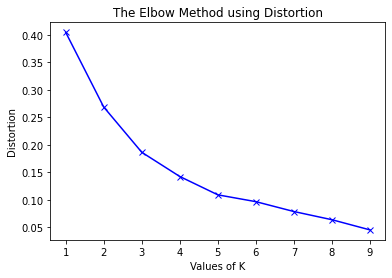

In [104]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [107]:
# add clustering labels
university_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

university_merged = gdl_uni_lat_long

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
university_merged = university_merged.join(university_grouped.set_index('University'), on='University')

university_merged.head() # check the last columns!

,Borough,University,Latitude,Longitude,Cluster Labels,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
0,Guadalajara Centro,Centro Universitario Azteca,20.675164,-103.347935,3.0,0.500000,0.0,0.083333,0.083333,0.000000,0.000000,0.000000,0.250000,0.0,0.083333
1,Guadalajara Centro,Universidad De Especialidades Plantel Centro (...,20.675511,-103.348775,3.0,0.538462,0.0,0.076923,0.076923,0.000000,0.000000,0.000000,0.230769,0.0,0.076923
2,Guadalajara Centro,Universidad De La Cienega Centro,20.674938,-103.347530,3.0,0.500000,0.0,0.083333,0.083333,0.000000,0.000000,0.000000,0.250000,0.0,0.083333
3,Obrera Centro,Universidad de Medios Audiovisuales (CAAV Gance),20.671262,-103.370426,0.0,0.636364,0.0,0.000000,0.000000,0.181818,0.090909,0.090909,0.000000,0.0,0.000000
4,Obrera Centro,Universidad de Medios Audiovisuales (CAAV),20.671253,-103.370333,0.0,0.636364,0.0,0.000000,0.000000,0.181818,0.090909,0.090909,0.000000,0.0,0.000000


In [108]:
university_merged = university_merged.dropna(axis=0)


In [109]:
university_merged['Cluster Labels'] = university_merged['Cluster Labels'].astype(np.int64)

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(university_merged['Latitude'], university_merged['Longitude'], university_merged['University'], university_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [111]:
university_merged.loc[university_merged['Cluster Labels'] == 0, university_merged.columns[[1] + list(range(5, university_merged.shape[1]))]]

,University,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
3,Universidad de Medios Audiovisuales (CAAV Gance),0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
4,Universidad de Medios Audiovisuales (CAAV),0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
5,infierno,0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
22,Universidad de Medios Audiovisuales (CAAV Gance),0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
23,Universidad de Medios Audiovisuales (CAAV),0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
24,infierno,0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
25,Universidad de Medios Audiovisuales (CAAV Gance),0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
26,Universidad de Medios Audiovisuales (CAAV Gree...,0.583333,0.0,0.0,0.0,0.166667,0.083333,0.083333,0.083333,0.0,0.0
27,Universidad de Medios Audiovisuales (CAAV),0.636364,0.0,0.0,0.0,0.181818,0.090909,0.090909,0.000000,0.0,0.0
28,Universidad Lamar,0.583333,0.0,0.0,0.0,0.166667,0.083333,0.083333,0.083333,0.0,0.0


In [112]:
university_merged.loc[university_merged['Cluster Labels'] == 1, university_merged.columns[[1] + list(range(5, university_merged.shape[1]))]]

,University,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
6,Hard to Find,0.0,0.181818,0.454545,0.0,0.090909,0.090909,0.0,0.090909,0.090909,0.0
33,Proulex Computación,0.0,0.000000,0.666667,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.0
38,Escuela de Bio-decodificacion,0.0,0.000000,0.666667,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.0
43,Universidad Nueva Galicia,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
44,Universidad Nueva Galicia,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [113]:
university_merged.loc[university_merged['Cluster Labels'] == 2, university_merged.columns[[1] + list(range(5, university_merged.shape[1]))]]

,University,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
12,Centro interinstiticional de Investigacion Edu...,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Universidad de Medios Audiovisuales (CAAV Godard),1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,la maroma . Formación en Circo y Teatro Fisico,0.75,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,Universidad Univer,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,IFLY Escuela de Vuelo,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,Colegio N Inglaterra,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,Instituto de Especialización para Ejecutivos,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,Universidad Virtual de Estudios Superiores,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,Univer Mar Egeo,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,Imainarte CIDMI,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
university_merged.loc[university_merged['Cluster Labels'] == 3, university_merged.columns[[1] + list(range(5, university_merged.shape[1]))]]

,University,Bookstore,Breakfast Spot,Cafeteria,Café,Coffee Shop,College Cafeteria,Coworking Space,Library,Restaurant,Snack Place
0,Centro Universitario Azteca,0.500000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.250000,0.000000,0.083333
1,Universidad De Especialidades Plantel Centro (...,0.538462,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.230769,0.000000,0.076923
2,Universidad De La Cienega Centro,0.500000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.250000,0.000000,0.083333
7,Escuela patagonica gastronomica,0.250000,0.166667,0.166667,0.000000,0.083333,0.083333,0.083333,0.083333,0.083333,0.000000
8,PATAGONICA escuela de alta cocina internacional,0.250000,0.166667,0.166667,0.000000,0.083333,0.083333,0.083333,0.083333,0.083333,0.000000
9,DELEM,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
10,Centro Universitario de Ciencias Sociales y Hu...,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
11,Estudios Políticos y Gobierno,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
15,Feria Del Empleo,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
16,Centro Universitario de Ciencias Sociales y Hu...,0.428571,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000
